# Naive ngram approach

https://www.kaggle.com/alvations/n-gram-language-model-with-nltk - ngram lm  
https://www.kaggle.com/anshulrai/cudnnlstm-implementation-93-7-accuracy - amazon reviews loader and data

In [1]:
from tqdm.notebook import tqdm

ngram_size = 6
data_amount = 100000000 # number of characters mb

# Load data

In [2]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet
import re
import os

In [3]:
train_file = bz2.BZ2File('data/amazonreviews/train.ft.txt.bz2')
train_file_lines = train_file.readlines(size=data_amount)

del train_file

train_file_lines = [x.decode('utf-8') for x in train_file_lines]


train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
 
                                                      
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        

del train_file_lines

gc.collect()
print(len(train_sentences))

220626


# Fit. Predict.

In [4]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lmura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from nltk import word_tokenize, sent_tokenize

# This is slow, I know, wygd
tokenized_sentences = list(tqdm(map(word_tokenize, train_sentences), total=len(train_sentences)))

In [6]:
from nltk.lm.preprocessing import padded_everygram_pipeline
training_ngrams, padded_sentences = padded_everygram_pipeline(ngram_size, tokenized_sentences)

In [7]:
from nltk.lm import MLE
model = MLE(ngram_size)
model.fit(tqdm(training_ngrams, total=len(train_sentences)), padded_sentences)
print(model.vocab)

KeyboardInterrupt: 

# Generation

In [72]:
def make_continuation(text):
    seed = word_tokenize(text)
    output = ' '.join(seed + model.generate(20, text_seed=seed))
    output = output[:output.find('</s>')] if output.find('</s>') != -1 else output
    return output

print(make_continuation('this iron is good . yet'))

this iron is good . yet when i picked up this book . i strongly suggest that you read them all . these books allowed my


# Sanity check

Draws various pathes model could have gone. Also saves this tree to file.

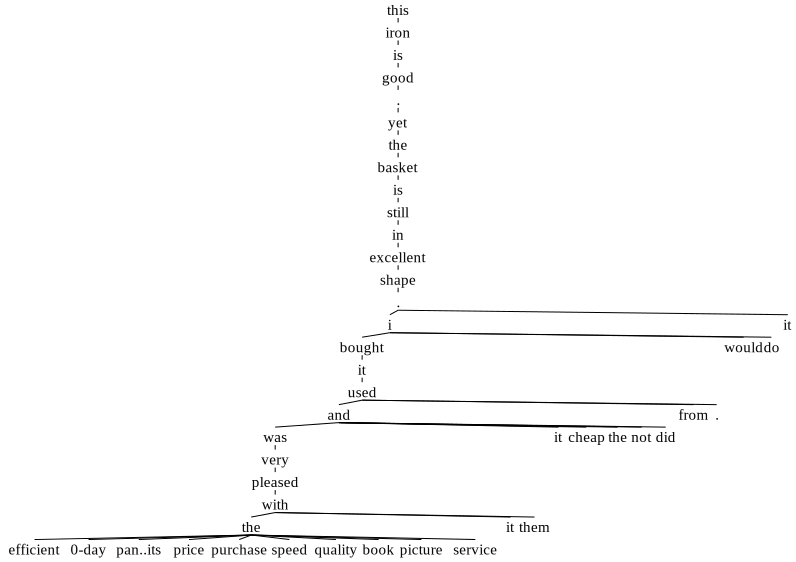

this iron is good . yet the basket is still in excellent shape . i bought it used and was very pleased with the service and


In [110]:
import svgling
import random

def draw_word_tree(model, text):
    words = ['*'] * (ngram_size - 2) + word_tokenize(text)

    prev_node = [words[len(words) - ngram_size - 2 + ngram_size - 1]] + \
                list(model.counts[words[len(words) - \
                ngram_size - 1:len(words) - ngram_size - 2 + ngram_size ]].keys())[:10]
    for i in range(len(words) - ngram_size - 1)[::-1]:
        predictions = list(model.counts[words[i:i + ngram_size - 1]].keys())[:10]
        prev_word = prev_node[0]
        leaves = [prev_word] + list(set(predictions) - set([prev_word]))
        new_node = [words[i + ngram_size - 2]] + leaves
        index = new_node.index(prev_word)
        new_node[index] = prev_node
        prev_node = new_node
        
    svgling.draw_tree(prev_node, distance_to_daughter=0.5, leaf_padding=0.2, font_size=15, horiz_spacing=svgling.core.HorizSpacing.TEXT).get_svg().saveas("test.svg")
    display(svgling.draw_tree(prev_node, distance_to_daughter=0.5, leaf_padding=0.2, font_size=15, horiz_spacing=svgling.core.HorizSpacing.TEXT))
    
output = make_continuation('this iron is good . yet')
draw_word_tree(model, output)
print(output)

# Save model

This pickle saving/restoring is impossibly slow. Training is faster

In [ ]:
import pickle 

with open('6gram_small.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open('6gram_small.pkl', 'rb') as file:
    model = pickle.load(file)

# Choose best from sampling

https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [ ]:
# from gensim.models import KeyedVectors
# word2vec = KeyedVectors.load_word2vec_format(
#     'GoogleNews-vectors-negative300.bin.gz', 
#     binary=True)

import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
vec_king = wv['king']